# Vorbereitungen

In [ ]:
#LOCAL dient als Unterscheidung, ob das Notebook lokal oder in Google-Colab ausgeführt wird.
#LOCAL == True bedeutet das Jupyter Notebook wird lokal ausgeführt.
#LOCAL == False bedeutet das Notebook wird in Google-Colab ausgeführt.
LOCAL = False


if LOCAL==False:
  # Einbinden des eigenen Google-Drive
  # - CLM auf den erscheinenden Link
  # - Google-Koto auswaehlen
  # - Die Verwendung zulassen (ggf. ganz nach unten scrollen)
  from google.colab import drive
  drive.mount('/content/drive')

  # Definition des Basis-Verzeichnisses
  # Dieses wird hier so festgelegt, dass man im Google-Drive unter
  #     /Colab_Drive/ML_TH/
  # arbeitet. Das BASEDIR MUSS BEREITS EXISTIEREN, also von Hand angelegt worden sein.
  BASEDIR='/content/drive/My Drive/Colab_Drive/ESP/'
else:
  BASEDIR='/tf/'

Mounted at /content/drive


In [ ]:
# Weitere vorausgesetzte Verzeichnisse anlegen
import os

DATADIR = 'data_input'
if os.path.exists(BASEDIR + DATADIR):
  print("Das Verzeichnis  "+BASEDIR+DATADIR+"   existiert bereits")
else:
  os.mkdir(BASEDIR + DATADIR)

TMPDIR = 'tmp'
if os.path.exists(BASEDIR + TMPDIR):
  print("Das Verzeichnis  "+BASEDIR+TMPDIR+"   existiert bereits")
else:
  os.mkdir(BASEDIR + TMPDIR)

Das Verzeichnis  /content/drive/My Drive/Colab_Drive/ESP/data_input   existiert bereits
Das Verzeichnis  /content/drive/My Drive/Colab_Drive/ESP/tmp   existiert bereits


Sicher stellen, dass librosa in Version 0.8.0 installiert wird und numpy in kompatibler Version, da ansonsten feature_extraction() von LogMelSpectrogram nicht funktioniert.

In [ ]:
# libs importieren
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa.util

import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import activations
from tensorflow.keras import Input

from tensorflow.keras import initializers
from tensorflow.keras import utils               # Hiervon wird to_categorical() benötigt

# Fuer das Handling von Bildern
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import save_img
from tensorflow.keras.utils import img_to_array

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Preprocessing der Daten


Setzen einiger Konstanten/Parameter:

In [ ]:
TARGET_SAMPLE_RATE = 16000  # Ziel Sample-Rate = 16 kHz
FRAME_LENGTH = 1024         # Frame-Länge in Samples
HOP_LENGTH = 512            # Überlappung der Frames (1024-512 = 512 Überlappung)
N_SAMPLES_PER_AUDIOSUBSAMPLE = HOP_LENGTH * 31 + FRAME_LENGTH

## Laden der Daten

In [ ]:
csv_file = os.path.join(BASEDIR + DATADIR, 'tags.csv')

# Festlegen der relevanten Merkmalsklassen (= Labels), müssen den Columns aus der CSV Datei matchen
class_names = ['bass', 'pitched', 'sustained', 'rhythmic', 'melodic']

# Einlesen der CSV-Datei (df = data frame)
labels_df = pd.read_csv(csv_file)

# Auswahl der relevanten Spalten basierend auf class_names
relevant_columns = ['UID'] + class_names
labels_df = labels_df[relevant_columns]

# Initialisierung der Listen für Daten und Labels
data = []
labels = []

# Iteriere über die Zeilen der CSV-Datei
for index, row in labels_df.iterrows():
    # Aufbauen des Pfades zur WAV-Datei
    wav_file = os.path.join((BASEDIR + DATADIR), f"{row['UID']}.wav")

    # Überprüfen, ob die WAV-Datei existiert
    if os.path.isfile(wav_file):
        # Laden der WAV-Datei, Resampling auf 16 kHz und Konvertierung in Mono
        samples, sample_rate = librosa.load(wav_file, sr=TARGET_SAMPLE_RATE, mono=True)

        # Hinzufügen zum Sample-Array
        data.append(samples)
        # Speichern der jeweiligen labels in separatem Array
        #labels.append(row[1:].values)
        # NaNs auf 0 setzen
        cleaned_labels = [int(x) if pd.notna(x) else 0 for x in row[1:].values]
        labels.append(cleaned_labels)
    else:
      print(f"file {row['UID']}.wav doesnt exist :(")

# Umwandlung in NumPy-Arrays für die weitere Verarbeitung
data_np = np.array(data, dtype=object)
labels_np = np.array(labels, dtype=int)

Als nächstes werden die Audio-Samples in Audiosubsamples mit einer Länge von jeweils N_SAMPLES_PER_AUDIOSUBSAMPLE Samples gekürzt, oder wenn ein Audiosample kürzer ist als N_SAMPLES_PER_AUDIOSUBSAMPLE Samples, aufgefüllt (zero-padding).

In [ ]:
# Vorbereiten der Listen für Audiosubsamples und ihre Labels
audiosubsamples = []
audiosubsample_labels = []

# Iteriere über alle Audiodateien
for i in range(data_np.shape[0]):
    file_length = len(data_np[i])
    n_audiosubsamples_in_file = file_length // N_SAMPLES_PER_AUDIOSUBSAMPLE

    # Generiere Subsamples
    for j in range(n_audiosubsamples_in_file):
        start_index = j * N_SAMPLES_PER_AUDIOSUBSAMPLE
        end_index = start_index + N_SAMPLES_PER_AUDIOSUBSAMPLE
        audiosubsamples.append(data_np[i][start_index:end_index])
        audiosubsample_labels.append(labels_np[i])

    # Wenn die Datei kürzer ist als N_SAMPLES_PER_AUDIOSUBSAMPLE, padde sie auf die Standardlänge
    if file_length < N_SAMPLES_PER_AUDIOSUBSAMPLE:
        padded_sample = np.pad(data_np[i], (0, N_SAMPLES_PER_AUDIOSUBSAMPLE - file_length), mode='constant', constant_values=0)
        audiosubsamples.append(padded_sample)
        audiosubsample_labels.append(labels_np[i])

# Konvertierung der Listen zurück in NumPy-Arrays
audiosubsamples_np = np.array(audiosubsamples, dtype=object)
audiosubsample_labels_np = np.array(audiosubsample_labels, dtype=int)

Nun kann die Verteilung der Eingabedaten auf die verschiedenen Merkmalsklassen betrachtet werden.

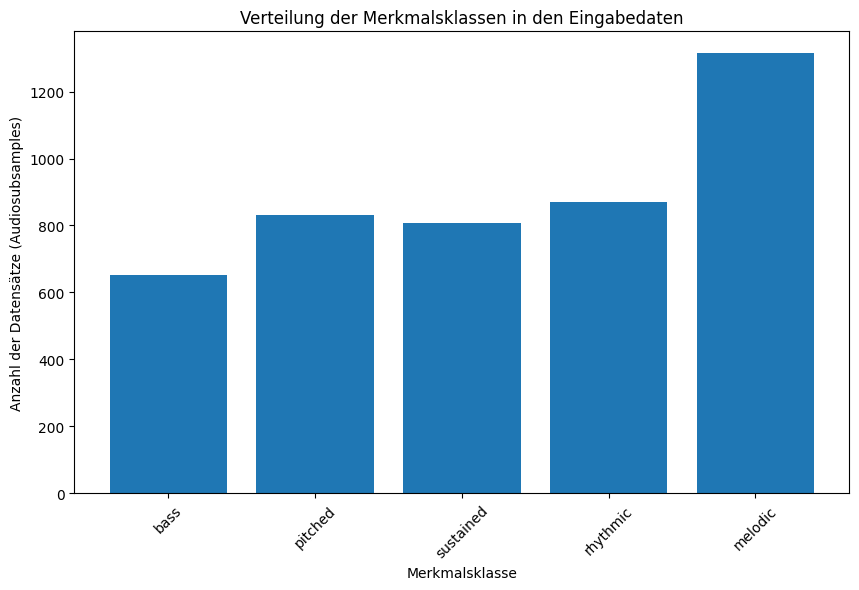

In [ ]:
label_sums = np.sum(audiosubsample_labels, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(class_names, label_sums)
plt.xticks(rotation=45)
plt.xlabel('Merkmalsklasse')
plt.ylabel('Anzahl der Datensätze (Audiosubsamples)')
plt.title('Verteilung der Merkmalsklassen in den Eingabedaten')
plt.show()

## Aufteilung in Entwicklungs- und Testdaten
Nun kann die erste Aufteilung in Entwicklungs- und Testdaten (Evaluierungsdaten) erfolgen.

In [ ]:
# Aufteilung in Entwicklungs- und Testdatensatz
x_dev, x_test, y_dev, y_test = train_test_split(audiosubsamples_np, audiosubsample_labels_np, test_size=0.2, random_state=42)

# Anzeige der Ergebnisse
print(f"Development Data: Total number of subsamples (datasets): {len(x_dev)} samples")
print(f"Test Data: Total number of subsamples (datasets): {len(x_test)} samples")

Development Data: Total number of subsamples (datasets): 2269 samples
Test Data: Total number of subsamples (datasets): 568 samples


## Aufsplitten der Audiosubsamples in Frames
Darüber hinaus werden die Samples in 1024 Samples lange, 512 Samples überlappende, Frames unterteilt. Dadurch entstehen 32 Frames je Audiosubsample, aus denen dann später die 32 Spalten der Spektrogramme berechnet werden.

In [ ]:
def create_frames(data):
    framed_data = []
    for sample in data:
        file_length = len(sample)
        n_audiosubsamples_in_file = file_length // N_SAMPLES_PER_AUDIOSUBSAMPLE

        if n_audiosubsamples_in_file < 1:
            # Pad sample, wenn es kleiner als ein Subsample ist
            sample = np.pad(sample, (0, N_SAMPLES_PER_AUDIOSUBSAMPLE - file_length), 'constant')
        else:
            # Berechne die benötigte Sample-Länge für korrekte Framing
            n_samples = (n_audiosubsamples_in_file * N_SAMPLES_PER_AUDIOSUBSAMPLE)
            sample = sample[:n_samples]

        # Frames erstellen
        frames = librosa.util.frame(sample, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        framed_data.append(np.transpose(frames))
    return framed_data


x_dev_framed = create_frames(x_dev)
x_test_framed = create_frames(x_test)

(32, 1024)


## Umwandeln der Samples in Spektrogramme

In [ ]:
#   This software component is licensed by ST under BSD 3-Clause license,
#   the "License"; You may not use this file except in compliance with the
#   License. You may obtain a copy of the License at:
#                        https://opensource.org/licenses/BSD-3-Clause

"""LogMel Feature Extraction example."""

import numpy as np
import sys
import librosa
import librosa.display
import scipy.fftpack as fft

SR = TARGET_SAMPLE_RATE
N_FFT = 1024
N_MELS = 30


def create_col(y):
    assert y.shape == (1024,)

    # Create time-series window
    fft_window = librosa.filters.get_window('hann', N_FFT, fftbins=True)
    assert fft_window.shape == (1024,), fft_window.shape

    # Hann window
    y_windowed = fft_window * y
    assert y_windowed.shape == (1024,), y_windowed.shape

    # FFT
    fft_out = fft.fft(y_windowed, axis=0)[:513]
    assert fft_out.shape == (513,), fft_out.shape

    # Power spectrum
    S_pwr = np.abs(fft_out)**2

    assert S_pwr.shape == (513,)

    # Generation of Mel Filter Banks
    mel_basis = librosa.filters.mel(sr=SR, n_fft=N_FFT, n_mels=N_MELS, htk=False)
    assert mel_basis.shape == (N_MELS, 513)

    # Apply Mel Filter Banks
    S_mel = np.dot(mel_basis, S_pwr)
    S_mel.astype(np.float32)
    assert S_mel.shape == (30,)

    return S_mel


def feature_extraction(y):
    assert y.shape == (32, 1024)

    S_mel = np.empty((30, 32), dtype=np.float32, order='C')
    for col_index in range(0, 32):
        S_mel[:, col_index] = create_col(y[col_index])

    # Scale according to reference power
    S_mel = S_mel / S_mel.max()
    # Convert to dB
    S_log_mel = librosa.power_to_db(S_mel, top_db=80.0)
    assert S_log_mel.shape == (30, 32)

    return S_log_mel

In [ ]:
def preprocess_data(x_framed, y):
    """
      Umwandlung der Samples in LogMel Spectogram Features. Mehr Informationen:
      https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505
      https://towardsdatascience.com/audio-deep-learning-made-simple-part-3-data-preparation-and-augmentation-24c6e1f6b52
      LogMel Sepctogram Features sind eine Art von Sepktogramm, Erklärung:
        1. Fourier-Transformation: Wandelt das Signal von Zeitabhängigkeit in Frequenzabhängigkeit um.
        2. Mel-Filterbank: Das Frequenzspektrum wird durch eine Reihe von Filtern verarbeitet, die
            auf der Mel-Skala basieren. Diese Skala approximiert die menschliche Hörwahrnehmung besser
            als die lineare Frequenzskalierung.
        3. Logarithmische Skalierung: Der Logarithmus der durch die Mel-Filterbank erhaltenen Energien
            wird genommen, um die Features an die logarithmische Wahrnehmung des menschlichen Gehörs
            anzupassen.
    """
    x_features = []
    y_features = []

    for i in tqdm(range(len(x_framed))):
        n_features_per_file = x_framed[i].shape[0] // 32

        for j in range(n_features_per_file):
            start_index = j * 32
            end_index = start_index + 32
            frame = x_framed[i][start_index:end_index]

            feature = feature_extraction(frame)
            x_features.append(feature)
            y_features.append(y[i])

    x_features = np.array(x_features, dtype='float32')
    y_features = np.array(y_features, dtype='int16')

    return x_features, y_features


x_dev_features, y_dev_features = preprocess_data(x_dev_framed, y_dev)
x_test_features, y_test_features = preprocess_data(x_test_framed, y_test)

100%|██████████| 568/568 [00:28<00:00, 19.97it/s]


In [ ]:
print(x_dev_features.shape)
print(y_dev_features.shape)
print(x_test_features.shape)
print(y_test_features.shape)

(2269, 30, 32)
(2269, 5)
(568, 30, 32)
(568, 5)


Nun kann das das erste Feature/Spektogramm geplottet werden um zu sehen, wie das aussieht.

In [ ]:
SAVE_SPECTROGRAMS_TO_PDF = False
N_SPECTROGRAMS = 10

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import librosa.display
import os

def logmel_spectrogram_to_pdf(feature, sr, title, pdf):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(feature,
                             sr=sr,
                             vmin=-80.0,
                             y_axis='mel', fmax=sr//2, x_axis='time',
                             cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()

    # Speichern der aktuellen Figur in der PDF
    pdf.savefig()  # Dies speichert die Figur in der PDF-Datei
    plt.close()  # Schließen Sie die Figur, um den Speicher freizugeben


if SAVE_SPECTROGRAMS_TO_PDF:
    # Pfad zur PDF-Datei
    save_path = BASEDIR + 'spectrograms.pdf'

    # Erstellen einer PDF-Datei, in der alle Plots gespeichert werden
    with PdfPages(save_path) as pdf:
        for index in range(N_SPECTROGRAMS):
            feature = x_dev_features[index]
            class_labels = [class_names[i] for i, value in enumerate(y_dev_features[index]) if value == 1]
            title = 'LogMel-Spektrogramm für ' + ', '.join(class_labels)

            plot_logmel_spectrogram(feature, sr=16000, title=title, pdf=pdf)

    print(f"Alle Spektrogramme wurden in {save_path} gespeichert.")

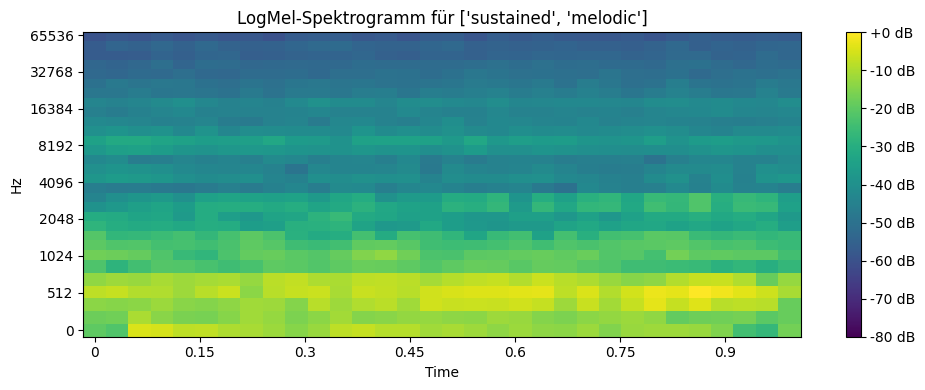

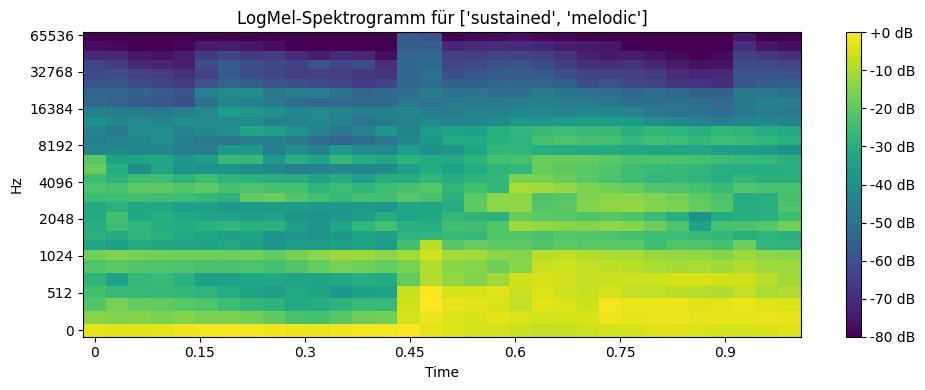

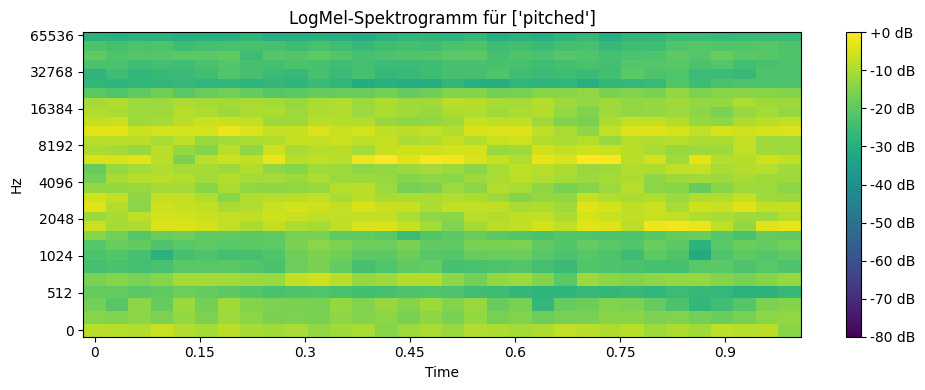

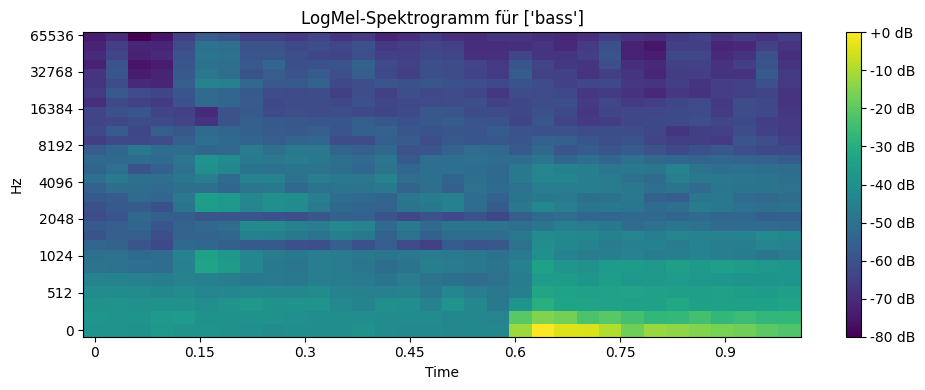

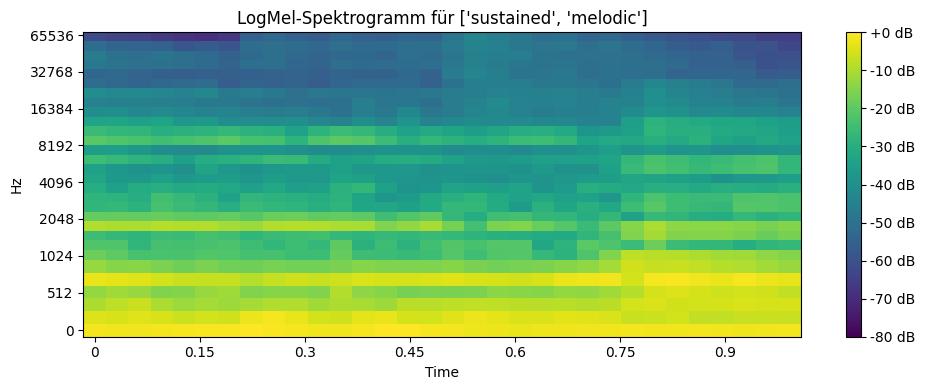

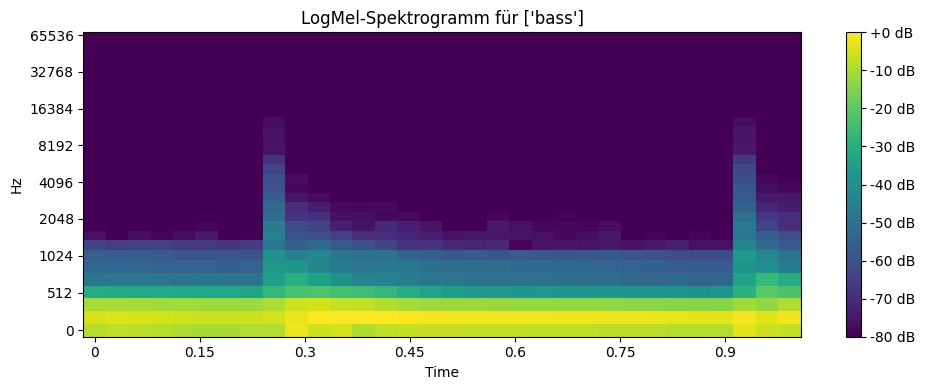

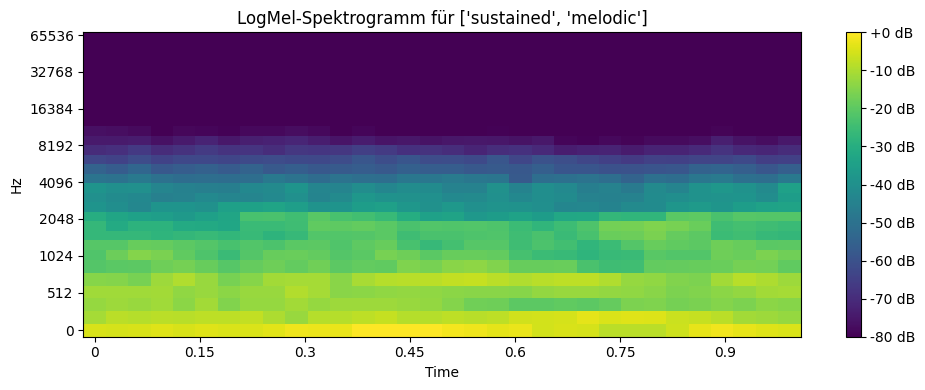

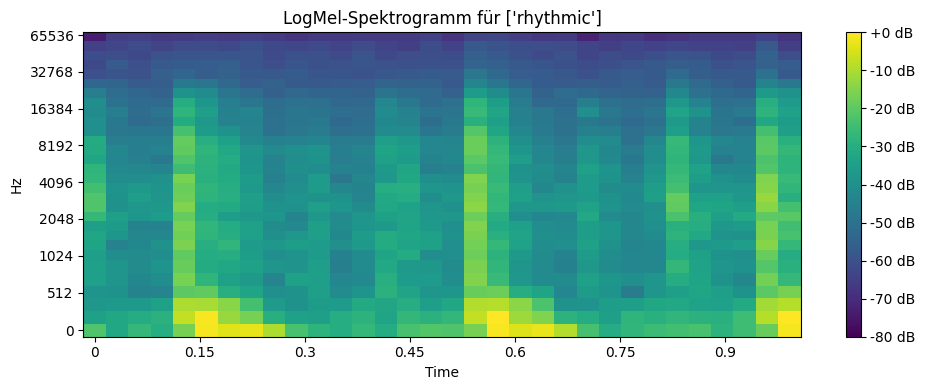

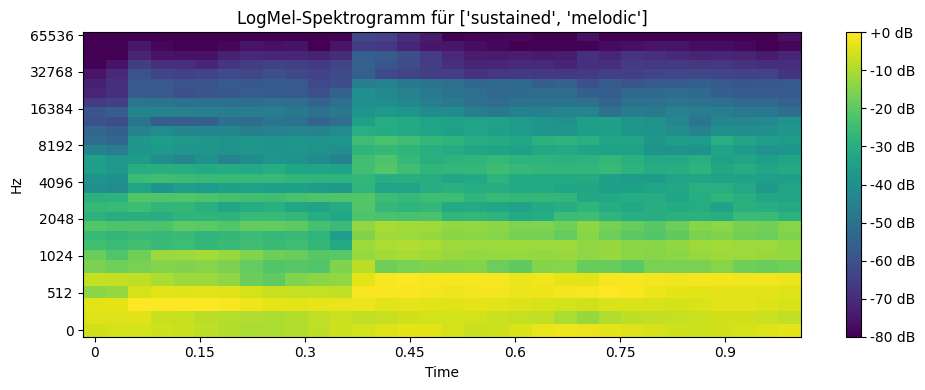

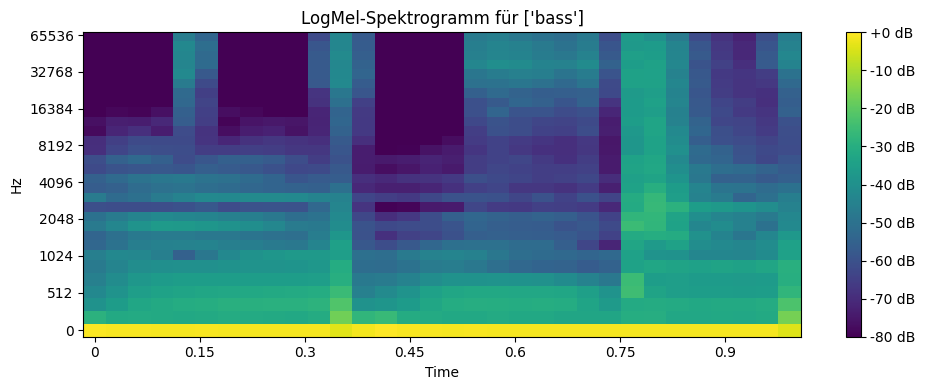

In [ ]:
# Visualisierung eines LogMel-Spektrogramms für ausgewählte Features
import matplotlib.pyplot as plt

def plot_logmel_spectrogram(feature, sr, title):
    plt.figure(figsize=(10, 4))
    # librosa.display.specshow(feature, sr=sr, y_axis='mel', fmax=16000, x_axis='time', cmap='viridis', vmin=-80.0)
    librosa.display.specshow(feature,
                             sr=sr,
                             vmin=-80.0,
                             y_axis='mel', fmax=64000, x_axis='time',
                             cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

for index in range(0, N_SPECTROGRAMS):
    feature = x_dev_features[index]
    # Konvertiere den entsprechenden Label-Index in einen Klassennamen, wenn y_dev_features direkte Indizes enthält
    class_labels = [class_names[i] for i, value in enumerate(y_dev_features[index]) if value == 1]
    title = f'LogMel-Spektrogramm für {class_labels}'
    plot_logmel_spectrogram(feature, sr=16000, title=title)


## Standardisierung

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import joblib

# features für scaling flattenen
x_dev_features_r = x_dev_features.reshape(len(x_dev_features), 30 * 32)
x_test_features_r = x_test_features.reshape(len(x_test_features), 30 * 32)

# scaler aus dem Entwicklungsdatensatz berechnen
scaler = preprocessing.StandardScaler().fit(x_dev_features_r)

# den scaler auf Entwicklungsdaten und Testdaten anwenden
x_dev_features_s = scaler.transform(x_dev_features_r)
x_test_features_s = scaler.transform(x_test_features_r)

# Scaler exportieren, um die Standardisierung später bei der Klassifikation von realen Daten nachahmen zu können
# Exportiere die Skalerparameter
mean = scaler.mean_
scale = scaler.scale_

# C-Datei mit den scaler Werten exportieren
featurescaler_export_file_path = os.path.join(BASEDIR, 'featurescaler.c')

# Scaler exportieren
joblib.dump(scaler, os.path.join(BASEDIR, 'scaler.pkl'))

# Speichere die Skalerparameter in ein C-kompatibles Format
with open(featurescaler_export_file_path, "w") as f:
    f.write("const float feature_scaler_mean[960] = {\n")
    for i in range(len(mean)):
        f.write(f"    {mean[i]:.6f}, ")
        if (i + 1) % 4 == 0:
            f.write("\n")
    f.write("};\n\n")
    f.write("const float feature_scaler_std[960] = {\n")
    for i in range(len(scale)):
        f.write(f"    {scale[i]:.6f}, ")
        if (i + 1) % 4 == 0:
            f.write("\n")
    f.write("};\n")

## Aufteilen der Entwicklungsdaten in Trainings-, und Validierungsdaten

In [ ]:
# Zweite Aufteilung: Aufteilung des Entwicklungsdatensatzes in Trainings- und Validierungsdatensatz
# dev (Entwicklungsdatensatz) wird aufgeteilt in:
# train => Trainingsdatensatz
# val => Validierungsdatensatz#
x_train, x_val, y_train, y_val = train_test_split(x_dev_features_s, y_dev_features, test_size=0.25, random_state=42)

x_test = x_test_features_s.reshape(len(x_test_features), 30 * 32)
y_test = y_test_features

print('Anzahl Datensätze:')
print('Trainigsdaten:', x_train.shape)
print('Validierungsdaten:', x_val.shape)
print('Testdaten:', x_test.shape)

Anzahl Datensätze:
Trainigsdaten: (1701, 960)
Validierungsdaten: (568, 960)
Testdaten: (568, 960)


## Speichern der Features
Speichern der Features in einer CSV-Datei in einem Format, das X-CUBE-AI verstehen kann, d.h. für jeden Tensor liegen die Werte in einem flattened Vektor vor.

In [ ]:
np.savetxt('x_train.csv', x_train.reshape(len(x_train), 30 * 32), delimiter=",")
np.savetxt('y_train.csv', y_train, delimiter=",")
np.savetxt('x_val.csv', x_val.reshape(len(x_val), 30 * 32), delimiter=",")
np.savetxt('y_val.csv', y_val, delimiter=",")
np.savetxt('x_test.csv', x_test.reshape(len(x_test), 30 * 32), delimiter=",")
np.savetxt('y_test.csv', y_test, delimiter=",")

# Bauen des Modells

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

# Setzen des Seeds für Reproduzierbarkeit
tf.random.set_seed(42)

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(30, 32, 1), data_format='channels_last'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

# Drucken der Modellzusammenfassung
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 30, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 13, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │          14,425 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,035 (66.54 KB)

 Trainable params: 17,035 (66.54 KB)

 Non-trainable params: 0 (0.00 B)

# Kompilierung des Modells

In [ ]:
from tensorflow.keras.optimizers import SGD

# SGD-Optimizer ohne Decay, da dies in der neuen API nicht direkt unterstützt wird
sgd = SGD(learning_rate=0.00005, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['acc'])


# Training des Modells




In [ ]:
# Reshape features to include channel
x_train_r = x_train.reshape(x_train.shape[0], 30, 32, 1)
x_val_r = x_val.reshape(x_val.shape[0], 30, 32, 1)
x_test_r = x_test.reshape(x_test.shape[0], 30, 32, 1)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Berechnung der Klassen-Gewichte
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
# class_weights_dict = dict(enumerate(class_weights))

# Train the model
history = model.fit(x_train_r, y_train, validation_data=(x_val_r, y_val),
                    batch_size=1, epochs=100, verbose=2)




Epoch 1/100
1701/1701 - 5s - 3ms/step - acc: 0.3733 - loss: 0.6507 - val_acc: 0.4859 - val_loss: 0.5923
Epoch 2/100
1701/1701 - 5s - 3ms/step - acc: 0.4738 - loss: 0.5462 - val_acc: 0.5581 - val_loss: 0.4925
Epoch 3/100
1701/1701 - 4s - 2ms/step - acc: 0.5438 - loss: 0.4464 - val_acc: 0.5669 - val_loss: 0.4275
Epoch 4/100
1701/1701 - 5s - 3ms/step - acc: 0.5438 - loss: 0.3913 - val_acc: 0.5687 - val_loss: 0.4012
Epoch 5/100
1701/1701 - 5s - 3ms/step - acc: 0.5438 - loss: 0.3686 - val_acc: 0.5704 - val_loss: 0.3896
Epoch 6/100
1701/1701 - 5s - 3ms/step - acc: 0.5450 - loss: 0.3569 - val_acc: 0.5687 - val_loss: 0.3819
Epoch 7/100
1701/1701 - 3s - 2ms/step - acc: 0.5432 - loss: 0.3489 - val_acc: 0.5669 - val_loss: 0.3759
Epoch 8/100
1701/1701 - 7s - 4ms/step - acc: 0.5473 - loss: 0.3427 - val_acc: 0.5687 - val_loss: 0.3709
Epoch 9/100
1701/1701 - 4s - 2ms/step - acc: 0.5479 - loss: 0.3379 - val_acc: 0.5669 - val_loss: 0.3668
Epoch 10/100
1701/1701 - 6s - 3ms/step - acc: 0.5503 - loss: 0.3

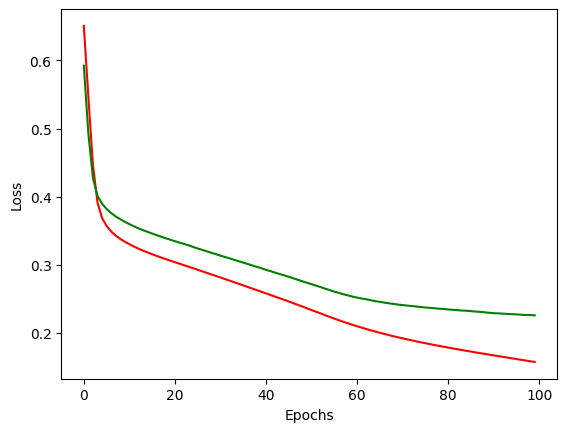

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, color='r')
plt.plot(val_loss, color='g')
plt.show()

# Evaluierung des Modells


## Evaluation der Accuracy

In [ ]:
loss_and_metrics = model.evaluate(x_test_r, y_test)

print('Testdaten loss:', loss_and_metrics[0])
print('Testdaten accuracy:', loss_and_metrics[1])

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.7224 - loss: 0.1940
Testdaten loss: 0.1991424560546875
Testdaten accuracy: 0.7130281925201416


## Confusion Matrix

### Confusion Matrix Validierungsdaten

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True labels: [4 1 1 1 1 1 2 0 2 0 3 3 1 2 3 0 4 3 0 3]
Predicted labels: [4 1 1 1 4 3 2 4 4 0 3 3 1 2 3 0 4 3 3 3]
Confusion Matrix (normalized):
[[0.67 0.11 0.01 0.13 0.08]
 [0.01 0.64 0.05 0.14 0.16]
 [0.04 0.01 0.41 0.02 0.53]
 [0.03 0.01 0.   0.95 0.01]
 [0.   0.   0.03 0.   0.97]]
Accuracy = 0.7007042253521126


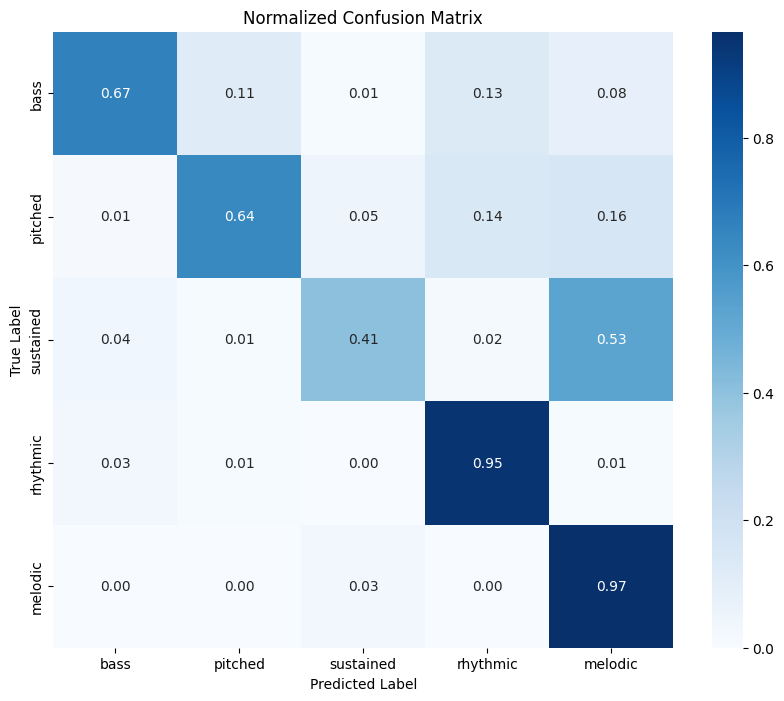

              precision    recall  f1-score   support

        bass       0.89      0.67      0.76       123
     pitched       0.86      0.64      0.73       160
   sustained       0.80      0.41      0.54       106
    rhythmic       0.73      0.95      0.83       119
     melodic       0.39      0.97      0.55        60

    accuracy                           0.70       568
   macro avg       0.73      0.73      0.68       568
weighted avg       0.78      0.70      0.70       568



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Klassennamen
class_names = ['bass', 'pitched', 'sustained', 'rhythmic', 'melodic']

# Berechnung der Vorhersagen und der Konfusionsmatrix
y_pred = model.predict(x_val_r)
y_pred_class_nb = np.argmax(y_pred, axis=1)
y_true_class_nb = np.argmax(y_val, axis=1)

# Ausgabe einiger Vorhersagen und wahren Labels
print("True labels:", y_true_class_nb[:20])
print("Predicted labels:", y_pred_class_nb[:20])

# Berechnung der Konfusionsmatrix
labels = np.arange(len(class_names))
matrix = confusion_matrix(y_true_class_nb, y_pred_class_nb, labels=labels)
accuracy = accuracy_score(y_true_class_nb, y_pred_class_nb)

# Normalisierung der Konfusionsmatrix
matrix_normalized = np.zeros_like(matrix, dtype=float)
for i in range(len(matrix)):
    if matrix[i].sum() != 0:
        matrix_normalized[i] = matrix[i].astype('float') / matrix[i].sum()

# Ausgabe der Konfusionsmatrix
np.set_printoptions(precision=2)
print("Confusion Matrix (normalized):")
print(matrix_normalized)
print("Accuracy = " + str(accuracy))

# Plot der Konfusionsmatrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_true_class_nb, y_pred_class_nb, target_names=class_names, labels=labels)
print(report)

# Modell speichern

In [ ]:
# Save the model into an HDF5 file ‘model.h5’
model.save(BASEDIR + 'model.h5')
model.save(BASEDIR + 'model.keras')

In [ ]:
# convert keras model to tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(BASEDIR + 'model.tflite', 'wb').write(tflite_model)

Saved artifact at '/tmp/tmpdlkeqxrv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 32, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132322992280096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132322992283792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132322992376288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132322992376464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132322992388432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132322992389312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132322992491152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132322992494672: TensorSpec(shape=(), dtype=tf.resource, name=None)


71472